# Natural Language Classification with Project Gutenberg

Our goal is to classify texts from Project Gutenberg by author. The corpus has been preprocessed in a separate notebook in order to avoid using unnecessary computational power each time this notebook is opened.

We have created a Tf-idf model of each document. This means the value associated with each word in each document is equal to the **term frequency**, i.e. the number of times the word appears in the document divided by the length, times the **inverse document frequency**, i.e. the total number of documents in the corpus divided by the number of documents containing the word.

We will start by exploring the data with some word clouds. Then we will use a Naive Bayes algorithm to classify the texts by author. We will then train the same classifier on a bigram model with an increase in accuracy.

In [1]:
import pandas as pd
import joblib
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [2]:
author_title_df = pd.read_csv('author_title.csv', index_col=0)
X = joblib.load('features.pkl')
X = X.toarray()
vocabulary = joblib.load('feature_names.pkl')

Y = author_title_df.Author

Word clouds are a relatively easy to understand way to visualize text data while still being somewhat information dense, so it will help to show word clouds for a few selected authors.

(-0.5, 799.5, 649.5, -0.5)

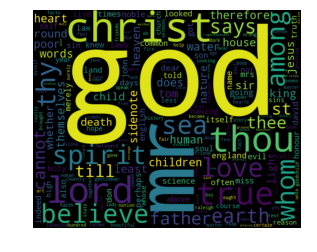

In [3]:
%matplotlib inline

dickens_docs = Y[Y == 'Charles Dickens'].index
dickens_freqs = X[dickens_docs].mean(axis=0)
dickens_wordfreq = dict(zip(vocabulary, dickens_freqs))
wordcloud = WordCloud(width=800,height=650)
wordcloud.generate_from_frequencies(dickens_wordfreq)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 799.5, 649.5, -0.5)

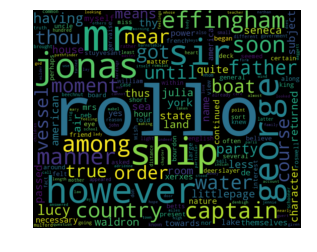

In [4]:
london_docs = Y[Y == 'Jack London'].index
london_freqs = X[london_docs].mean(axis=0)
london_wordfreq = dict(zip(vocabulary, london_freqs))
wordcloud = WordCloud(width=800,height=650)
wordcloud.generate_from_frequencies(london_wordfreq)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 799.5, 649.5, -0.5)

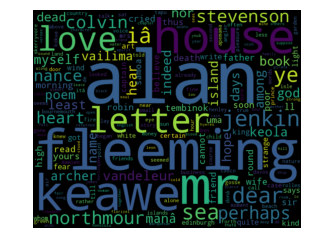

In [5]:
pkd_docs = Y[Y == 'Philip Kindred Dick'].index
pkd_freqs = X[pkd_docs].mean(axis=0)
pkd_wordfreq = dict(zip(vocabulary, pkd_freqs))
wordcloud = WordCloud(width=800,height=650)
wordcloud.generate_from_frequencies(pkd_wordfreq)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

Now on to the classification. We will first split the data into train and test sets. Here we are using 30% of the data as the test set.

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size = 0.3,
                                                    random_state = 4)

In [7]:
clf = MultinomialNB()
params = {'alpha':np.logspace(-7,1,9)}
gridcv = GridSearchCV(clf, param_grid = params)
gridcv.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-07,   1.00000e-06,   1.00000e-05,   1.00000e-04,
         1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [8]:
gridcv.best_estimator_

MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True)

In [9]:
%%time
clf = MultinomialNB(alpha = .0001)
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))

0.905952380952
CPU times: user 13.2 s, sys: 1.54 s, total: 14.7 s
Wall time: 9.18 s


We have been using a bag of words model, where it simply looks at the (idf adjusted) frequency of each word in the document. Sometimes, however, it is helpful to look at the interactions between words.

Our next step will look at a bigram model, where each feature represents two adjacent words. It performs slower but we will expect here to see some improvement in accuracy.

In [10]:
vectorizer = TfidfVectorizer(input='filename', min_df=3, max_df=.95, ngram_range=(2,2), encoding='iso-8859-1')
X_bigram = vectorizer.fit_transform(['txt/'+fname for fname in author_title_df.Name])

X_train, X_test, Y_train, Y_test = train_test_split(X_bigram, Y,
                                                              test_size = 0.3,
                                                              random_state = 4
                                                             )

In [11]:
%%time
clf = MultinomialNB(alpha = .0001)
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))

0.921428571429
CPU times: user 1min, sys: 37.7 s, total: 1min 38s
Wall time: 2min 14s
